<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RTML_RNNregression_WithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Calculate speed and distances
epsilon = 1e-5  # Small constant to avoid division by zero
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [4]:
# Handle potential infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)  # Fill NaNs with the mean of the column


In [5]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(
    data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']]
)

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps + 1
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix-1].to_numpy()
        seq_y = data.iloc[end_ix-1][['Latitude', 'Longitude']].to_numpy()
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Prepare sequences
grouped = data.groupby('Tag')
X, y = [], []
for _, group in grouped:
    sequences = create_sequences(group[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']], n_steps=5)
    X.append(sequences[0])
    y.append(sequences[1])

X = np.concatenate(X)
y = np.concatenate(y)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [13]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size , hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        h = encoder_outputs
        energy = torch.tanh(self.attn(h))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class LSTMModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        lstm_out, _ = self.lstm(x)
        attention_weights = self.attention(lstm_out)
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_out).squeeze(1)
        output = self.fc(context)
        return output

model = LSTMModel(hidden_size=128).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()




Epoch 1: Training Loss: 0.0010217795613633328, Validation Loss: 3.9224252773272016e-05
Epoch 2: Training Loss: 3.121678613959482e-05, Validation Loss: 3.674312785502509e-05
Epoch 3: Training Loss: 1.9743980935045462e-05, Validation Loss: 2.950874462651714e-05
Epoch 4: Training Loss: 1.6887315447187603e-05, Validation Loss: 2.039907821204768e-05
Epoch 5: Training Loss: 1.5383971537636604e-05, Validation Loss: 1.0440879102157758e-05
Epoch 6: Training Loss: 1.4489274408090395e-05, Validation Loss: 1.292944204169278e-05
Epoch 7: Training Loss: 1.367729201816055e-05, Validation Loss: 1.6229192422340726e-05
Epoch 8: Training Loss: 1.3226599177507757e-05, Validation Loss: 1.538943139985881e-05
Epoch 9: Training Loss: 1.2723214229138401e-05, Validation Loss: 1.3233554630064413e-05
Epoch 10: Training Loss: 1.2289103817560584e-05, Validation Loss: 1.5321501743958695e-05
Epoch 11: Training Loss: 1.2122081369234776e-05, Validation Loss: 1.073338588279711e-05
Epoch 12: Training Loss: 1.168519380128

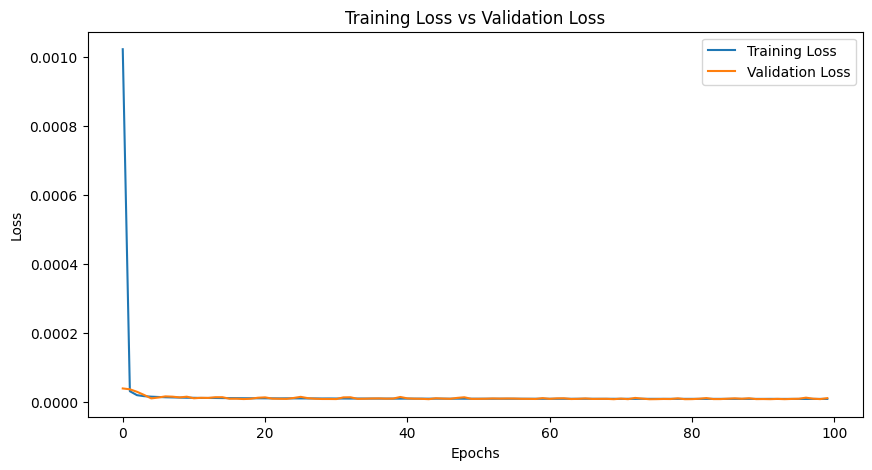

In [16]:
# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)

In [17]:
# Load Model Function
def load_model(model, load_path='model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model

Actual: [-12.720042  33.08736 ], Predicted: [-12.720272  33.091328]
Actual: [-13.080032  33.06432 ], Predicted: [-13.080313  33.065342]
Actual: [-12.63811  33.08524], Predicted: [-12.639377  33.091885]
Actual: [-13.191322  33.06588 ], Predicted: [-13.191496  33.06584 ]
Actual: [-13.03468   33.299633], Predicted: [-13.033678  33.300407]
Actual: [-12.872728  33.22156 ], Predicted: [-12.871802  33.223534]
Actual: [-13.134173  33.241386], Predicted: [-13.129466  33.24283 ]
Actual: [-12.92964  33.25989], Predicted: [-12.929988  33.26545 ]
Actual: [-13.080723  33.057503], Predicted: [-13.0811615  33.05884  ]
Actual: [-13.107233  33.123375], Predicted: [-13.109392  33.123104]

Average Loss: 1.1146064648190292e-05
Latitude RMSE: 0.00372433590276256, Longitude RMSE: 0.004451479477359857


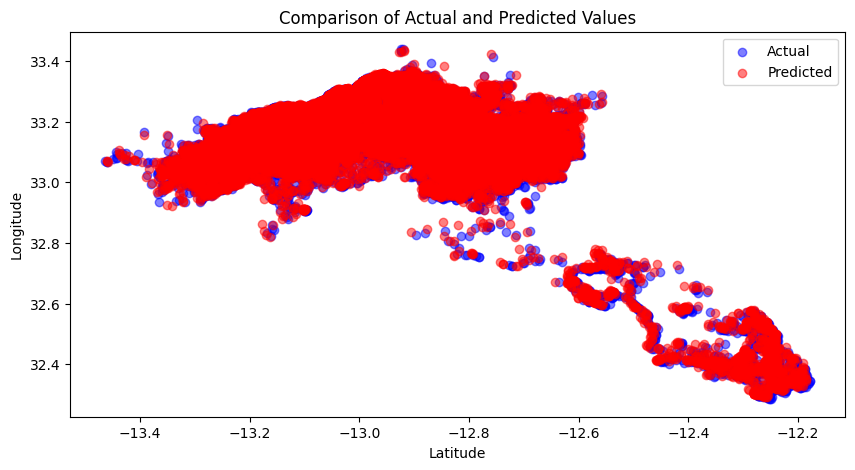

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [19]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class RNNModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.rnn = nn.RNN(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        rnn_out, _ = self.rnn(x)
        attention_weights = self.attention(rnn_out)
        context = torch.bmm(attention_weights.unsqueeze(1), rnn_out).squeeze(1)
        output = self.fc(context)
        return output

rnn_model = RNNModel(hidden_size=128).to('cuda')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.83513786169586e-06, Validation Loss: 1.2891639000787236e-05
Epoch 2: Training Loss: 8.856631376015136e-06, Validation Loss: 9.152047830618951e-06
Epoch 3: Training Loss: 8.853834195895966e-06, Validation Loss: 1.0191178643221135e-05
Epoch 4: Training Loss: 8.77561427964936e-06, Validation Loss: 9.258629086931128e-06
Epoch 5: Training Loss: 8.850998714118313e-06, Validation Loss: 9.199120314066536e-06
Epoch 6: Training Loss: 8.834971681415453e-06, Validation Loss: 9.220170780356699e-06
Epoch 7: Training Loss: 8.834936546839054e-06, Validation Loss: 8.23341186769114e-06
Epoch 8: Training Loss: 8.801714862417072e-06, Validation Loss: 9.005581828437064e-06
Epoch 9: Training Loss: 8.817597493551775e-06, Validation Loss: 1.0099852978833927e-05
Epoch 10: Training Loss: 8.804697536374577e-06, Validation Loss: 8.744156928745695e-06
Epoch 11: Training Loss: 8.74716736940702e-06, Validation Loss: 8.991168236183605e-06
Epoch 12: Training Loss: 8.750294133297277e-06, Valid

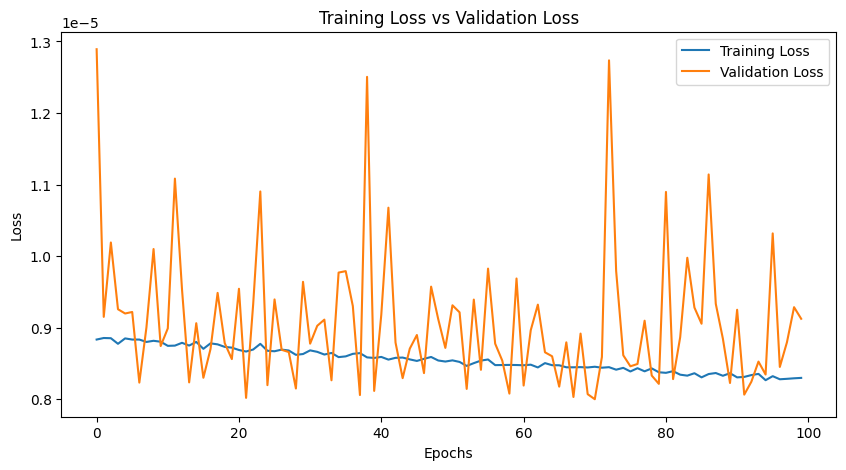

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_SimpleRNN.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_SimpleRNN.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.891493  33.26806 ], Predicted: [-12.892849  33.270332]
Actual: [-13.021333  33.20799 ], Predicted: [-13.022063  33.20774 ]
Actual: [-12.94167  33.23554], Predicted: [-12.940573  33.23873 ]
Actual: [-12.882537  33.23781 ], Predicted: [-12.885139  33.241573]
Actual: [-12.84229   33.187782], Predicted: [-12.843542  33.18902 ]
Actual: [-12.857903  33.241425], Predicted: [-12.859924  33.24347 ]
Actual: [-13.290105  32.992126], Predicted: [-13.286082  32.991386]
Actual: [-12.789142  33.21151 ], Predicted: [-12.794493  33.211765]
Actual: [-13.041193  33.187153], Predicted: [-13.041219  33.184853]
Actual: [-13.004873  33.212658], Predicted: [-13.006707  33.213436]

Average Loss: 9.126208650769431e-06
Latitude RMSE: 0.0037538888211752362, Longitude RMSE: 0.0037279213112521668


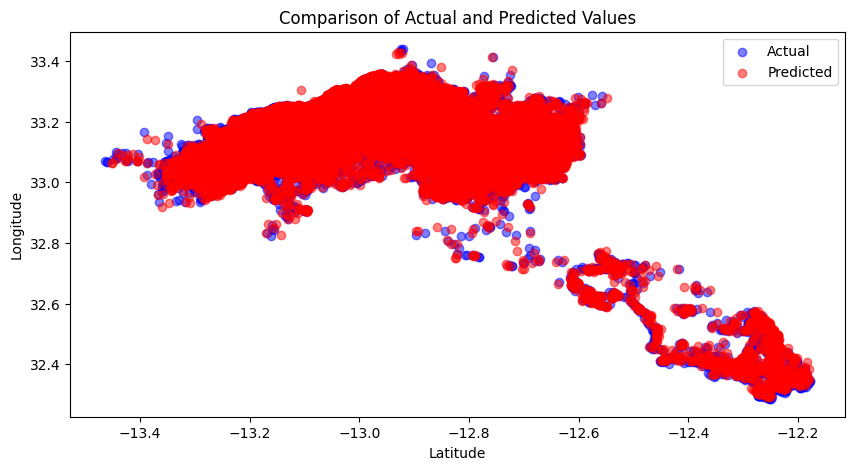

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [22]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class GRUModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.gru = nn.GRU(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        gru_out, _ = self.gru(x)
        attention_weights = self.attention(gru_out)
        context = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)
        output = self.fc(context)
        return output

gru_model = GRUModel(hidden_size=128).to('cuda')
criterion_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.289123759833529e-06, Validation Loss: 8.50552273861487e-06
Epoch 2: Training Loss: 8.264751410459176e-06, Validation Loss: 1.293671848102763e-05
Epoch 3: Training Loss: 8.2721390884874e-06, Validation Loss: 8.738235546288835e-06
Epoch 4: Training Loss: 8.264568476913976e-06, Validation Loss: 8.719358134663873e-06
Epoch 5: Training Loss: 8.25701859467603e-06, Validation Loss: 8.331395280614061e-06
Epoch 6: Training Loss: 8.26013879460604e-06, Validation Loss: 8.716634476882987e-06
Epoch 7: Training Loss: 8.260159337891238e-06, Validation Loss: 8.672494576851642e-06
Epoch 8: Training Loss: 8.223515669821718e-06, Validation Loss: 8.135905016315337e-06
Epoch 9: Training Loss: 8.234269397050841e-06, Validation Loss: 9.26741555169547e-06
Epoch 10: Training Loss: 8.198079419688216e-06, Validation Loss: 8.03793954292847e-06
Epoch 11: Training Loss: 8.21315830929428e-06, Validation Loss: 8.56424101166051e-06
Epoch 12: Training Loss: 8.222812287528054e-06, Validation Lo

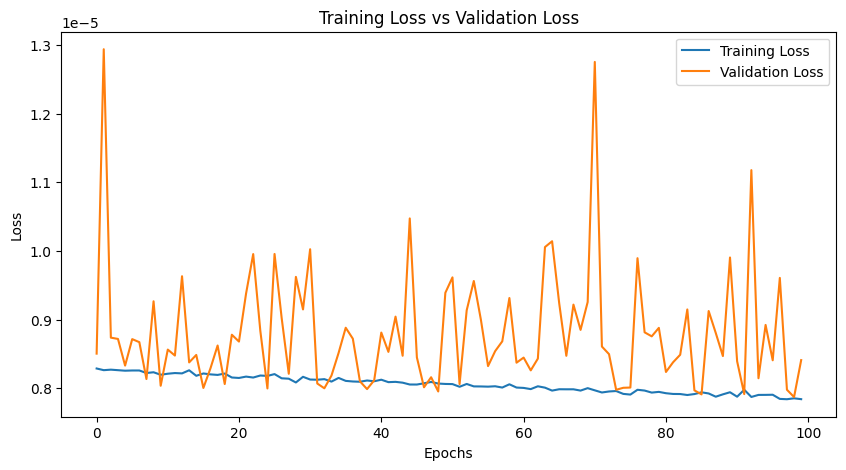

In [23]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_GRU.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_GRU.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.7260275  33.107445 ], Predicted: [-12.725629  33.10765 ]
Actual: [-13.065575  33.073624], Predicted: [-13.064998  33.075497]
Actual: [-13.181755  33.20468 ], Predicted: [-13.181359  33.202812]
Actual: [-12.73065  33.07545], Predicted: [-12.732623  33.068733]
Actual: [-12.843785  33.166794], Predicted: [-12.846194  33.16713 ]
Actual: [-12.866767  33.226006], Predicted: [-12.869063  33.22609 ]
Actual: [-12.814483  33.200497], Predicted: [-12.816658  33.2026  ]
Actual: [-12.863398  33.212933], Predicted: [-12.869628  33.212788]
Actual: [-13.137278  33.226936], Predicted: [-13.142001  33.22956 ]
Actual: [-13.054747  33.088444], Predicted: [-13.053239  33.09206 ]

Average Loss: 8.409772143542732e-06
Latitude RMSE: 0.003547129838594667, Longitude RMSE: 0.0036263991704523725


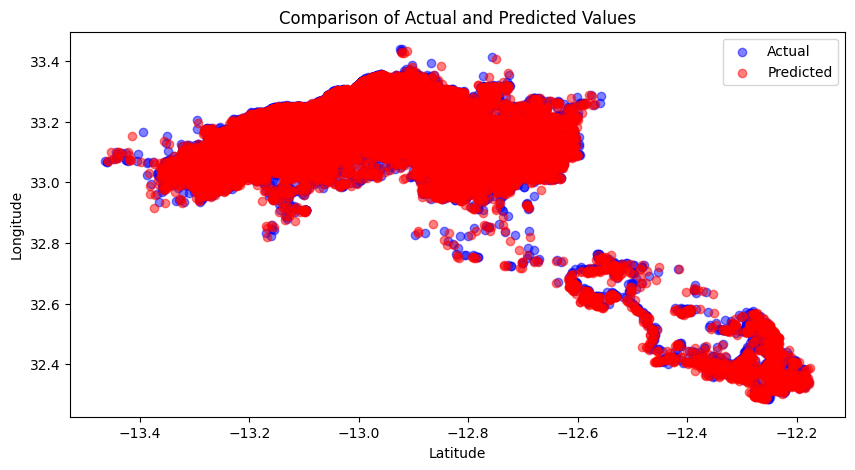

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    lat_rmse = []
    lon_rmse = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                lat_rmse.append((actual[0] - predicted[0])**2)
                lon_rmse.append((actual[1] - predicted[1])**2)
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    lat_rmse = np.sqrt(np.mean(lat_rmse))
    lon_rmse = np.sqrt(np.mean(lon_rmse))

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')
    print(f'Latitude RMSE: {lat_rmse}, Longitude RMSE: {lon_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)
